In [1]:
# you need these commands / libraries in order to manipulate arrays and plot stuff inline.
# So always run this cell prior to any of the other python cells here.  You can run a cell by 
# clicking on it, holding shift and pressing return.  I put it at the beginning 
# just so I remember to run it every time I want to play with this notebook.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

# What you seem to be looking at

The slide you sent me contains the scratchings typically associated with the teaching of 'time series' analysis.  These are regression problems where your input is always time (in some denomination) and your output is e.g., a stock price, temperature, whatever.  More specifically - its getting at a 'global' approach to time series, where you try to fit a known function (with weights that must be tuned properly) to your data.  Often times this function is the sum of several simpler ones - e.g., in your case a linear and periodic (repeating sinusoid) one.

In order to better grasp stuff like this I suggest using a nice tool like the jupyter notebook here.  In it you can both write math (in markdown cells) and run python (or any other language you want really) in code cells.  I like these because they let you scratch out thoughts in a markdown cell, while playing with plots, algorithms, etc., in code cells.

Here I'll try to convince you of their utility by going through some examples of time series data, plotting some functions we might (after tuning their parameters appropriately) want to fit to these datasets in order to make meaningful predictions, and then finally tune those parameters and fit those functions to the time series data.

# Here are a few examples of 'time series' data.

First up - total student debt in the U.S.  No big shocker here - its just increasing like mad.  Like a straight line going up.  The input here is time (in quarters of a year) and the output is total student debt (in trillions of dollars)

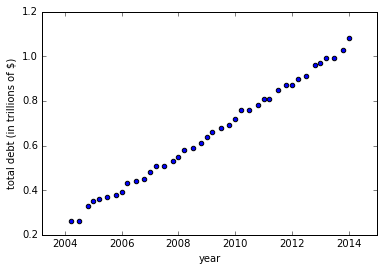

In [2]:
my_data = np.genfromtxt('student_debt.csv', delimiter=',')
x = my_data[:,0].reshape((len(my_data),1))
y = my_data[:,1].reshape((len(my_data),1))
h = plt.scatter(x,y)
plt.xlim(np.min(x)-1,np.max(x)+1)
plt.xlabel('year')
plt.ticklabel_format(useOffset=False, style='plain')
plt.ylabel('total debt (in trillions of $)')

Next - a weird one - "milk per pound per cow" measured in England I think, from 1962 - 1975.  Got it from here

https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line

It was the first one on the list when I googled 'periodic time series data'.  Its quite wiggly, with the trend increasing and decreasing during the same times every year, but the overall trend also increases over time.    

I chose this dataset because its 'easy' - its got a linear overall trend (increasing) with a sinusoidal (periodic) wavey-ness annually over time.  So a simple function (or model) is going to fit to it quite nicely. 

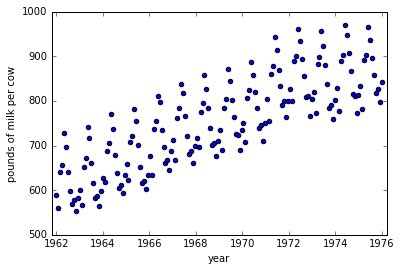

In [3]:
my_data = np.genfromtxt('milk.out', delimiter=',')
x = my_data[:,0].reshape((len(my_data),1))
y = my_data[:,1].reshape((len(my_data),1))
h = plt.scatter(x,y)
plt.xlabel('year')
plt.xlim(np.min(x)-0.2,np.max(x)+0.2)
plt.ticklabel_format(useOffset=False, style='plain')
plt.ylabel('pounds of milk per cow')

Finally - a more interesting dataset - the average monthly price of one barrel of oil over the last several decades.

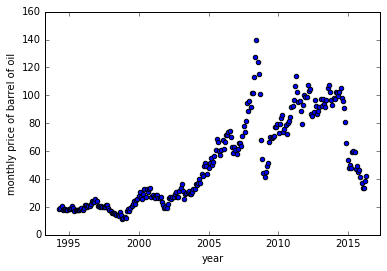

In [4]:
my_data = np.genfromtxt('oil.out', delimiter=',')
x = my_data[:,0].reshape((len(my_data),1))
y = my_data[:,1].reshape((len(my_data),1))
h = plt.scatter(x,y)
plt.xlim(np.min(x)-1,np.max(x)+1)
plt.xlabel('year')
plt.ylabel('monthly price of barrel of oil')

So - we have some data. The first one is pretty linear, the second quite wavy and repeating while generally increasing, and the third one is weird.

In each case we want to say something meaningful about what will happen in the future.  Maybe in the first two instances we can say right away - without doing any math etc., - something meaningful.  But can we say anything about the price of oil - just by looking at its previous prices?  Not sure.

Moreover we want to quantify predictions on even the 'easy looking' ones  - and so now we need some math.  And more specifically we need to "fit a known function" to each of these datasets.  This just means we will fit - as best we can - some (possibly wiggly) function we already understand fairly well in order to make an educated quantified guess at what will happen in the future in each instance.


# Lets look at some sine waves

The function shown in one of your slideshows, it has some parameters that we'll tune later to fit it to each dataset as best as possible, is 

\begin{equation}
y = w_0 + w_1t + w_2\text{sin}(2\pi{}t-\phi)
\end{equation}

Now note here I've removed the 'subscripts' off of $y$ and $t$: $y$ here is a function of $t$ and all these weights $w_0$, $w_1$, etc., and removed the 'divided by 12' on the inside for simplicity (all this can be added back in later if we want).  This is a pretty flexible function that we can use to fit to the timeseries datasets I showed you above.  

But before we look at this function, lets look at a sine wave - a simple sine wave without all the weights and stuff.  Then lets add back in some of those knobs and whistles.  

So - a simple sine wave.  It looks like this.

\begin{equation}
f = \text{sin}(2\pi{}t)
\end{equation}

It goes up and down, repeating itself every time $t$ increases by 1.  Lets plot this thing.

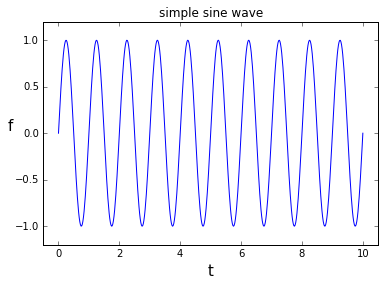

In [5]:
# plot a sine wave over the interval [0,10]
t = np.linspace(0,10,500)         # gives us a nice sample of values over [0,10]
f = np.sin(2*np.pi*t)

# plot it and make things pretty
plt.plot(t,f)
plt.title('simple sine wave')
plt.xlim(-0.5,10.5)
plt.ylim(-1.2,1.2)
plt.xlabel('t',fontsize = 15)
plt.ylabel('f',rotation = 0,fontsize = 15)

On this interval [0,10] the wave goes up and down 10 times, repeating itself.  Notice $f(0) = 0$ and $f(10) = 0$.  This function has a 'period' equal to 1, that is it repeats itself every time $t$ moves forward by $1$.

A more complicated version of the sine wave has parameters or weights in it that we can use to a) shift if left and right b) scale it (make it larger or smaller vertically) and c) adjust the period (make it repeat more or less often).  Adding in the parameter that shifts it left and right - this is typically called the 'phase' - and the sine wave looks like this

\begin{equation}
f = \text{sin}(2\pi{}t - \phi)
\end{equation}

If we plot it with say a phase of $\phi = 0.5$ we will just shift the sine wave to the left by $0.5$.  We won't change its period - that will still be one.  And we won't change its height - still $1$ there as well.  You can plot it to make sure - like below


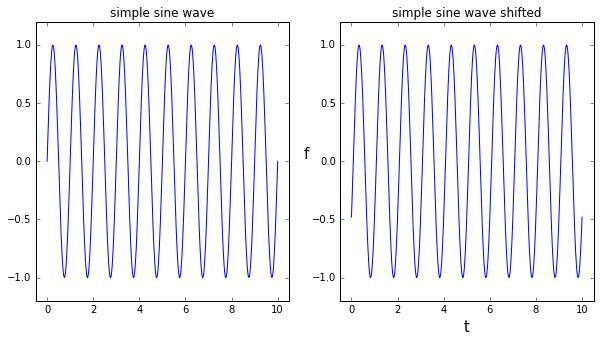

In [6]:
# plot a sine wave over the interval [0,10]
t = np.linspace(0,10,500)         # gives us a nice sample of values over [0,10]
f = np.sin(2*np.pi*t)
f_shifted = np.sin(2*np.pi*t - 0.5)

# plot it and make things pretty
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True,figsize = (10,5))

ax1.plot(t,f)
ax1.set_title('simple sine wave')
ax1.set_xlim(-0.5,10.5)
ax1.set_ylim(-1.2,1.2)

ax2.plot(t,f_shifted)
ax2.set_title('simple sine wave shifted')
ax2.set_xlim(-0.5,10.5)
ax2.set_ylim(-1.2,1.2)
ax2.set_xlabel('t',fontsize = 15)
ax2.set_ylabel('f',rotation = 0,fontsize = 15)

If instead we add two more parameters, one to adjust the vertical height of the sine wave and another to change its period we have the more complicated looking sine wave formula

\begin{equation}
f = w_2\text{sin}(w_32\pi{}t - \phi)
\end{equation}

Here the $w_3$ parameter adjusts the height of the wave (or its 'amplitude') - notice all the previous ones have just gone from -1 to 1 in height.  But if we crank this up, the wave gets taller.  The $w_3$ weight on the inside adjusts the length of the period - or how often the wave repeats itself.  This is often called the 'frequency' of a sine wave.  The bigger we make this parameter, the shorter the period becomes.

TO THE PLOTTING CHAMBERS - lets choose some values for these weights and plot an example.  

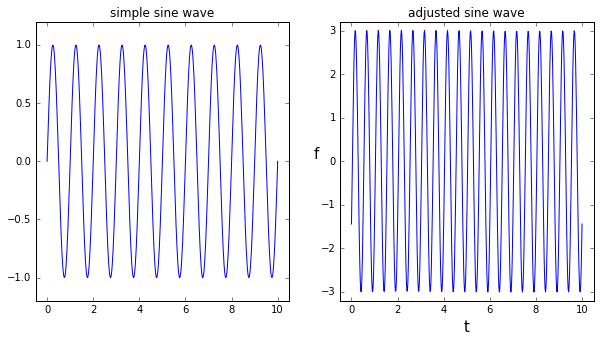

In [7]:
# plot a sine wave over the interval [0,10]
t = np.linspace(0,10,500)         # gives us a nice sample of values over [0,10]
f = np.sin(2*np.pi*t)

# now plot an adjusted sin wave - with a phase shift, and ampliftude and frequency adjusting parameters
w_2 = 3
w_3 = 2
phi = 0.5
f_adjusted = w_2*np.sin(w_3*2*np.pi*t - 0.5)

# plot it and make things pretty
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True,figsize = (10,5))

ax1.plot(t,f)
ax1.set_title('simple sine wave')
ax1.set_xlim(-0.5,10.5)
ax1.set_ylim(-1.2,1.2)

ax2.plot(t,f_adjusted)
ax2.set_title('adjusted sine wave')
ax2.set_xlim(-0.5,10.5)
ax2.set_ylim(-w_2 - 0.2, w_2 + 0.2)
ax2.set_xlabel('t',fontsize = 15)
ax2.set_ylabel('f',rotation = 0,fontsize = 15)

The sine wave on the left was the original, without any of these added parameters.  The one on the right has those parameters set so that its both stretched out vertically,  so that it oscillates more, and its shifted to the left by 0.5.

Now lets plot the original $y$ function, the one with all the weights, for a fixed set of random weights $w_0$, $w_1$, etc.,  Again from your slidewhow it looks like

\begin{equation}
y = w_0 + w_1t + w_2\text{sin}(2\pi{}t-\phi)
\end{equation}

Notice: it does NOT have a parameter messing with the frequency - its set fixed at 1 period.

I say we plot each piece (the linear part $w_0 + w_1t$, and the sin part $w_2\text{sin}(2\pi{}t-\phi)$) individually, then both togeteher to see whats happening.  What $y$ looks like.  Run the cell below a bunch of times to see different instances - where the weights are given different values - to see just how flexible this thing is.

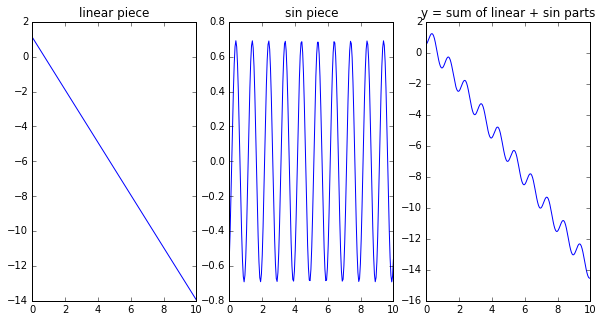

In [8]:
## you can run this cell again and again to see new versions of y - with new random weights
# generate y and its linear / sin piece over some range - lets just use [0,10]
t = np.linspace(0,10,200)         # gives us a nice sample of values over [0,10]
w_0 = np.random.randn(1)      # assign random value to each weight
w_1 = np.random.randn(1)
w_2 = np.random.rand(1) + 0.2 # make this one positive, but still random
phi = np.random.randn(1)
linear_part = w_0 + w_1*t
sin_part = w_2*np.sin(2*np.pi*t - phi)
y = w_0 + w_1*t + w_2*np.sin(2*np.pi*t - phi)

# plot em
f, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True,figsize = (10,5))
ax1.plot(t,linear_part)
ax1.set_title('linear piece')
ax2.plot(t,sin_part)
ax2.set_title('sin piece')
ax3.plot(t,y)
ax3.set_title('y = sum of linear + sin parts')

We can see that the linear part - in the left panel - is just linear.  Just a line with a slope - it can point upwards or downwards.  In the middle is the sin part - its just a sine wave.  Notice that its again periodic with period 1 (there is no parameter changing the period here) just like the simple sine wave we plotted before.  In the right panel is the sum of these two parts - or $y$.  Since its a straight up sum it looks roughly like the line in the left panel in that it points upward if the line points upward, and downward if the line points downward, etc., only now its wiggly like the sine wave in the middle panel.

If you ran that cell above a few times you can maybe get the intuition - this thing is flexible enough to fit to all of the time series datasets I showed you above.  Of course each time we fit it we'll have to adjust the weights differently.  But it can be done.  Look.  I'm not saying its the greatest function ever - it won't be able to fit EVERYTHING, every dataset well - but for the three above its probably good enough.

# Fitting the function to each time series dataset

Now lets finally get back to the specific equation from the slide you sent me

\begin{equation}
y_i = w_0 + w_1t + w_2\text{sin}(2\pi{}t_i-\phi)
\end{equation}

I've added back the subscripts.  Notice what these subscripts indicate - a datapoint is denoted by the pair $(t_i,y_i)$ - $t_i$ is the input value, while $y_i$ is the output.  This is the $i^{th}$ datapoint, and one usually says (to be general) that a dataset consists of say $P$ such datapoints written like $(t_1,y_1), (t_2,y_2), ... ,(t_P,y_P)$.

Fine.  What do we want to do?  For each of the three datasets we want to tune these weights appropriately so that

\begin{equation}
y_i \approx w_0 + w_1t + w_2\text{sin}(2\pi{}t_i-\phi)
\end{equation}

for each $i$.  Notice I've changed the $=$ sign to $\approx$ because there's likely no way we can tune the weights to get exact equality.

Now.  Tuning those weights requires something called 'mathematical optimization'.  This is a technical subject that requires some of those math ideas listed in one of our previous emails.  

Side note -  the only reason that 'trigonometric identity' is used in the slide you sent me is that it makes this technical chore computationally easier.  Thats it.  Thats the whole reason they introduce it.  

In any case, I wouldn't worry about the details of this until you've got handy with some of the math.  Just be sure - it can be done.  

Below is a little (code) function that will do it for you.  All you need is to load in set of input/output data, and out will pop the proper weights.  The input and output are in matching-length vectors $\bf{x}$ and $\bf{y}$.  

In [9]:
# tunes weights properly
def optimize_weights(x,y):
    P = len(y)
    
    # start loop to create Q and r 
    Q = 0
    r = 0
    for p in range(0,P):
        # make sure to transform input appropriately using sin/cos waves
        x_p = feature_transform(xin = x[p])  # stack 1 on top of pth point
        y_p = y[p]

        # update Q
        Q+= x_p*x_p.T           # careful - this is an outer product of vectors

        # update d
        r-= y_p*x_p

    # now that the matrix and vector are constructed we can solve for the proper weights
    w = np.linalg.solve(Q,-r)
    return w
        
# tranform input data
def feature_transform(xin):
    D = 1      # preset degree
    period = 1 # period of sinusoids
    N = np.size(xin)
    feat = np.zeros((2*(D+1),N))
    feat[0,:] = 1
    temp = xin
    if N > 1:
        temp =  xin.flatten()
    feat[1,:] = temp
    for d in range(1,D+1):
        feat[2*d,:] = np.sin(d*2*np.pi*temp)
        feat[2*d+1,:] = np.cos(d*2*np.pi*temp)
    return feat
                    
# function that we will fit to the data - feed in input range and weights
def y_function(indata,weights):
    feat = feature_transform(xin = indata)
    ytest = np.dot(feat.T,weights)
    return ytest

# compute the average error of the function model on the dataset
def compute_ave_error(x,y,w):
    # transform the input
    P = len(y)
    error = 0
    for p in range(0,P):
        x_p = feature_transform(xin = x[p])  # stack 1 on top of pth point
        y_p = y[p]
        error+= (np.dot(x_p.T,w)-y_p)**2
    ave_error = error/float(P)
    return ave_error

Lets go back and fit the time series datasets one by one.

First the student debt data

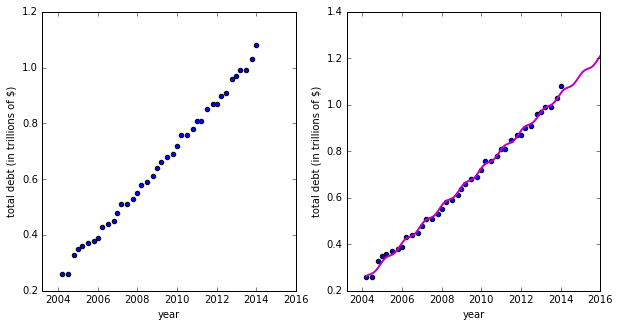

In [10]:
# load the data and plot
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True,figsize = (10,5))
my_data = np.genfromtxt('student_debt.csv', delimiter=',')
x = my_data[:,0].reshape((len(my_data),1))
y = my_data[:,1].reshape((len(my_data),1))
ax1.scatter(x,y)
ax1.set_xlabel('year')
ax1.set_ylabel('total debt (in trillions of $)')
ax1.set_xlim(np.min(x)-1,np.max(x)+2)
ax1.ticklabel_format(useOffset=False, style='plain')

ax2.scatter(x,y)
ax2.set_xlabel('year')
ax2.set_ylabel('total debt (in trillions of $)')
ax2.set_xlim(np.min(x)-1,np.max(x)+2)
ax2.ticklabel_format(useOffset=False, style='plain')

# now tune the parameters of our function to the data and show the result
w =  optimize_weights(x,y)
t = np.linspace(min(x),max(x)+2,500)
y_out = y_function(indata = t,weights = w)
ax2.plot(t,y_out,color = 'm',Linewidth = 2)

Although the final model (in pink) is a little wavy -  clearly we could have done a fine job by just using the linear part of the function. I mean, the data is increasing pretty linearly.  In other words, even if we chopped off the sinusoid part we would still fit this dataset just fine.

With this model for the data we can now make a quantifiable educated guess at how big the total amount of student debt in the U.S. will be in the "future", say in the year 2014.  All we need to do is plug $t=2014$ into the function with our learned weights.  We get

In [11]:
t = 2016
y_t = y_function(indata = t,weights = w)
print 'if the current trend continnues ten at time = ' + str(t) + ' total student debt is predicted to be ' + str(y_t[0][0]) + ' trillion dollars'

if the current trend continnues ten at time = 2016 total student debt is predicted to be 1.20962924701 trillion dollars


Next - the milk dataset.  

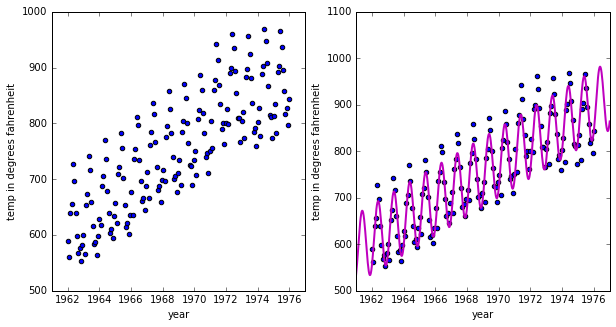

In [12]:
# load the data and plot
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True,figsize = (10,5))
my_data = np.genfromtxt('milk.out', delimiter=',')
x = my_data[:,0].reshape((len(my_data),1))
y = my_data[:,1].reshape((len(my_data),1))

ax1.scatter(x,y)
ax1.set_xlabel('year')
ax1.set_ylabel('temp in degrees fahrenheit')
ax1.set_xlim(np.min(x)-1,np.max(x)+1)
ax1.ticklabel_format(useOffset=False, style='plain')

ax2.scatter(x,y)
ax2.set_xlabel('year')
ax2.set_ylabel('temp in degrees fahrenheit')
ax2.set_xlim(np.min(x)-1,np.max(x)+1)
ax2.ticklabel_format(useOffset=False, style='plain')

# now tune the parameters of our function to the data and show the result
w =  optimize_weights(x,y)
t = np.linspace(min(x)-1,max(x)+1,500)
y_out = y_function(indata = t,weights = w)
ax2.plot(t,y_out,color = 'm',Linewidth = 2)

It looks pretty good - not perfect, but it'll get the job done -  and it should.  It was the perfect dataset - a linearly upward trending wavy set of data.  

Finally - the oil dataset.  Lets get fitting.

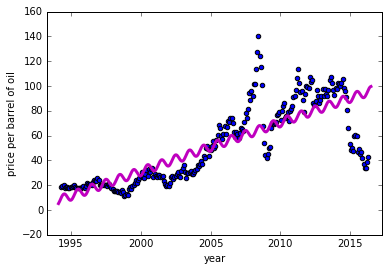

In [13]:
my_data = np.genfromtxt('oil.out', delimiter=',')
x = my_data[:,0].reshape((len(my_data),1))
y = my_data[:,1].reshape((len(my_data),1))

h = plt.scatter(x,y)
plt.xlim(np.min(x)-1,np.max(x)+1)
plt.xlabel('year')
plt.ylabel('price per barrel of oil')

# now tune the parameters of our function to the data and show the result
w =  optimize_weights(x,y)
t = np.linspace(min(x)-0.2,max(x)+0.2,500)
y_out = y_function(indata = t,weights = w)
plt.plot(t,y_out,color = 'm',Linewidth = 3)

LOL.  Not happening.  Thats because the pattern here is more complicated than linear + 1-period periodic wavy.  So the function we are trying to fit to the data is just not flexible enough to fit very well.

We would have to try another, more flexible function.  In your other slide - they hint at this idea.  We can sum up more simple functions - not just one linear and one sinusoidal one.   

Alternatively instead of taking this 'global' view of regression we take a more local one - there are several options here and they often work pretty well too.  We can talk about those if you're interested.